<a href="https://colab.research.google.com/github/jamiroquai1225/Forecasting/blob/main/ARIMA%2C_Prophet%2C_LSTM_stock%20forecasting%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model

In [ ]:
# 주가 데이터 수집 
!pip install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pystan~=2.14 # fbprophet 설치 
!pip install cmdstanpy>=1.0.4
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
from fbprophet import Prophet 

import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX

from fbprophet import Prophet

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model

In [ ]:
def step_split(x_sequence, y_sequence, n_steps, n_features, n_forwards, n_predict_steps, test_set=False):
  x_sequence = np.array(x_sequence).reshape(-1, n_features)
  y_sequence = np.array(y_sequence).reshape(-1, 1)

  X, y = list(), list()
  if test_set:
    X = x_sequence[-n_steps:]
    X = np.array(X)
    X = X.reshape(1, n_steps, n_features)
  else:
    end = len(x_sequence) - n_steps - n_forwards - n_predict_steps + 2
    for i in range(end):
      seq_x = x_sequence[i:i+n_steps]
      seq_y = y_sequence[i+n_steps+n_forwards-1:i+n_steps+n_forwards+n_predict_steps-1]
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y


def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(32,
                batch_input_shape=(batch_size, n_steps, n_features),
                stateful=stateful))
    model.add(Dense(1))
    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
# 주가 데이터 가져오기
naver_df = yf.download('035420.KS',
                      start='2021-01-01',
                      end='2022-10-05',
                      progress=False)

In [ ]:
df = naver_df
df['ds'] = pd.to_datetime(naver_df.index, format = '%Y-%m-%d') 
df['y'] = df['Close']
df = df[['ds', 'y']]
print(df)

                                                 ds         y
Date                                                         
2021-01-04 00:00:00+09:00 2021-01-04 00:00:00+09:00  293000.0
2021-01-05 00:00:00+09:00 2021-01-05 00:00:00+09:00  292500.0
2021-01-06 00:00:00+09:00 2021-01-06 00:00:00+09:00  290000.0
2021-01-07 00:00:00+09:00 2021-01-07 00:00:00+09:00  289500.0
2021-01-08 00:00:00+09:00 2021-01-08 00:00:00+09:00  312000.0
...                                             ...       ...
2022-09-27 00:00:00+09:00 2022-09-27 00:00:00+09:00  204500.0
2022-09-28 00:00:00+09:00 2022-09-28 00:00:00+09:00  200500.0
2022-09-29 00:00:00+09:00 2022-09-29 00:00:00+09:00  196500.0
2022-09-30 00:00:00+09:00 2022-09-30 00:00:00+09:00  193500.0
2022-10-04 00:00:00+09:00 2022-10-04 00:00:00+09:00  176500.0

[431 rows x 2 columns]


In [ ]:
naver_df = yf.download('035420.KS',
                      start='2021-01-01',
                      end='2022-10-05',
                      progress=False)

naver_df = naver_df[["Close"]] 

naver_df = naver_df.reset_index()
naver_df

,Date,Close
0,2021-01-04 00:00:00+09:00,293000.0
1,2021-01-05 00:00:00+09:00,292500.0
2,2021-01-06 00:00:00+09:00,290000.0
3,2021-01-07 00:00:00+09:00,289500.0
4,2021-01-08 00:00:00+09:00,312000.0
...,...,...
426,2022-09-27 00:00:00+09:00,204500.0
427,2022-09-28 00:00:00+09:00,200500.0
428,2022-09-29 00:00:00+09:00,196500.0
429,2022-09-30 00:00:00+09:00,193500.0


In [ ]:
# datetime의 timezon 제거하기 
naver_df['Date'] =naver_df['Date'].dt.tz_localize(None)
naver_df

,Date,Close
0,2021-01-04,293000.0
1,2021-01-05,292500.0
2,2021-01-06,290000.0
3,2021-01-07,289500.0
4,2021-01-08,312000.0
...,...,...
426,2022-09-27,204500.0
427,2022-09-28,200500.0
428,2022-09-29,196500.0
429,2022-09-30,193500.0


In [ ]:
df = naver_df
df['ds'] = df['Date']
df['price'] = df['Close']
df

,Date,Close,ds,price
0,2021-01-04,293000.0,2021-01-04,293000.0
1,2021-01-05,292500.0,2021-01-05,292500.0
2,2021-01-06,290000.0,2021-01-06,290000.0
3,2021-01-07,289500.0,2021-01-07,289500.0
4,2021-01-08,312000.0,2021-01-08,312000.0
...,...,...,...,...
426,2022-09-27,204500.0,2022-09-27,204500.0
427,2022-09-28,200500.0,2022-09-28,200500.0
428,2022-09-29,196500.0,2022-09-29,196500.0
429,2022-09-30,193500.0,2022-09-30,193500.0


In [ ]:
df = naver_df
df['price'] = df['Close']
df

,Close,ds,price
Date,,,
2021-01-04,293000.0,2021-01-04,293000.0
2021-01-05,292500.0,2021-01-05,292500.0
2021-01-06,290000.0,2021-01-06,290000.0
2021-01-07,289500.0,2021-01-07,289500.0
2021-01-08,312000.0,2021-01-08,312000.0
...,...,...,...
2022-09-27,204500.0,2022-09-27,204500.0
2022-09-28,200500.0,2022-09-28,200500.0
2022-09-29,196500.0,2022-09-29,196500.0


In [ ]:
df = df.drop(['Close'], axis = 1) # 열삭제
df = df.drop(['ds'], axis = 1) # 열삭제
df

,price
Date,
2021-01-04,293000.0
2021-01-05,292500.0
2021-01-06,290000.0
2021-01-07,289500.0
2021-01-08,312000.0
...,...
2022-09-27,204500.0
2022-09-28,200500.0
2022-09-29,196500.0


In [ ]:
df

,price
Date,
2021-01-04,293000.0
2021-01-05,292500.0
2021-01-06,290000.0
2021-01-07,289500.0
2021-01-08,312000.0
...,...
2022-09-27,204500.0
2022-09-28,200500.0
2022-09-29,196500.0


In [ ]:
df = df['Date']
df

KeyError: ignored

In [ ]:
df.index = df['Date']
df.set_index('Date', inplace=True)

In [ ]:
# 분석용 데이터 set 
df

,price
Date,
2021-01-04,293000.0
2021-01-05,292500.0
2021-01-06,290000.0
2021-01-07,289500.0
2021-01-08,312000.0
...,...
2022-09-27,204500.0
2022-09-28,200500.0
2022-09-29,196500.0


In [ ]:
# 2000년 부터의 데이터만 사용
X = df[df.index >= datetime.datetime(2021,1,4)]
y = df[df.index >= datetime.datetime(2021,1,4)]

#LSTM의 학습과 예측 기간 설정
n_steps = 30
training_period = 100 + n_steps
n_features = 1
n_forwards = 1
n_predict_steps = 1

#테스트 기간 설정
end = len(X) - n_steps - training_period
validation_size = 10
start = end - validation_size

In [ ]:
#예측 결과를 담을 리스트 만들기
yhat_arima_list = list()
yhat_prophet_list = list()
yhat_logistic_prophet_list = list()
yhat_lstm_list = list()
y_real_list = list()
predict_index_list = list()

#LSTM의 학습 파라미터 설정
stateful = True
batch_size = 1
epochs = 1

In [ ]:
#LSTM모델의 사전 학습
lstm_model = create_model(stateful,batch_size,n_steps,n_features)
data_x = X[start-training_period:start].values.reshape(-1, n_features)
data_y = y[start-training_period:start].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data_x)
data_x = scaler.transform(data_x)
data_y = scaler.transform(data_y)
x_train, y_train = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps)


pretrain_epoch = 60
for j in range(pretrain_epoch): 
  print(f'Epoch {j + 1}/{pretrain_epoch}')
  lstm_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=1,
                    verbose=2,
                    shuffle=False,
                    validation_split=0.1
                      )
  lstm_model.reset_states()

TypeError: ignored

In [ ]:
from tqdm.notebook import tqdm_notebook

In [ ]:
#one-step time series forecast시작
for i in tqdm_notebook(range(start, end)):
  # 학습은 과거 전 구간이 아닌 예측날 기준 512일 이전의 데이터만 학습하도록 하겠다.
  data = X[i:i+training_period+n_steps]
  y_real = X.values[i+training_period+n_steps].item()
  y_real_list.append(y_real)
  predict_index = X.index[i+training_period+n_steps].date()
  predict_index_list.append(predict_index)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#SARIMA모델 정의와 학습
sarima_model = SARIMAX(data.values, order=(0,2,2), seasonal_order=(0, 1, 1, 12), trend='c', enforce_stationarity=False, enforce_invertibility=False)
model_fit = sarima_model.fit()
sarima_forecast = model_fit.forecast(1).item()
yhat_arima_list.append(sarima_forecast)

In [ ]:
#Prophet모델 정의와 학습
prophet_model = Prophet(daily_seasonality = False)
prophet_series = pd.DataFrame([data.index, data['price']]).T
prophet_series.columns = ['ds','y']
prophet_model.fit(prophet_series)
future =  prophet_model.make_future_dataframe(periods=1)
prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
yhat_prophet_list.append(prophet_forecast)  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
 #LSTM모델용 데이터 전처리 
data_x = data.values.reshape(-1, n_features)
data_y = data.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data_x)
  
data_x = scaler.transform(data_x)
data_y = scaler.transform(data_y)
  

x_train, y_train = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps)
x_test, _ = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps, True)

In [ ]:
#LSTM 모델 예측 실시
lstm_model.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=1,
               verbose=0,
               shuffle=False
               )
lstm_model.reset_states()
lstm_forecast = scaler.inverse_transform(lstm_model.predict(x_test, batch_size=batch_size)).item()
yhat_lstm_list.append(lstm_forecast)

In [ ]:
for i in tqdm_notebook(range(start, end)):
  data = X[i:i+training_period+n_steps]

  prophet_series = pd.DataFrame([data.index, data['price']]).T
  prophet_series.columns = ['ds','y']
  prophet_model = Prophet(growth = 'logistic', daily_seasonality = False)
  prophet_series['cap'] = prophet_series['y'].shift() * 1.1
  prophet_series['floor'] = prophet_series['y'].shift() * 0.9
  prophet_series.fillna(method='bfill', inplace=True)

  prophet_model.fit(prophet_series)
  future =  prophet_model.make_future_dataframe(periods=1)
  future['cap'] = prophet_series['cap'].append(pd.Series(prophet_series['y'].values[-1]*1.1),ignore_index=True)
  future['floor'] = prophet_series['floor'].append(pd.Series(prophet_series['y'].values[-1]*0.9),ignore_index=True)
  future.fillna(method='bfill', inplace=True)


  prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
  yhat_logistic_prophet_list.append(prophet_forecast)  

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [ ]:
result_df = pd.DataFrame(list(zip(y_real_list, yhat_arima_list,yhat_prophet_list,
                                  yhat_logistic_prophet_list,yhat_lstm_list)),columns=['y','arima','prophet','prophet_logistic','lstm'],index=predict_index_list)
col_list = ['arima', 'prophet','prophet_logistic','lstm']
for col in col_list:
  mse = mean_squared_error(result_df['y'], result_df[col])
  print(f'{col} error: {mse}')

arima error: 817554394.3801197
prophet error: 69232826.60980085
prophet_logistic error: 934644.6188967418
lstm error: 817558755.4689941


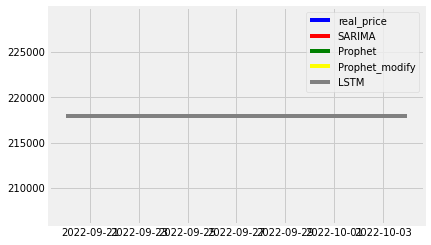

In [ ]:
result_df = pd.DataFrame(list(zip(y_real_list, yhat_arima_list,yhat_prophet_list,yhat_logistic_prophet_list,yhat_lstm_list)),
                         columns=['y','arima','prophet','prophet_logistic','lstm'],index=predict_index_list)
result_df['ratio'] = result_df['y'].diff() / result_df['y'].shift()
result_df['y_shifted'] = result_df['y'].shift()
result_df['arima_direction'] = result_df.apply(lambda x: 1 if (x['arima'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['prophet_direction'] = result_df.apply(lambda x: 1 if (x['prophet'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['prophet_logistic_direction'] = result_df.apply(lambda x: 1 if (x['prophet_logistic'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['lstm_direction'] = result_df.apply(lambda x: 1 if (x['lstm'] - x['y_shifted']) > 0 else 0, axis=1) 

result_df['arima_simulation'] = result_df['y'][0]
result_df['prophet_simulation'] = result_df['y'][0]
result_df['prophet_logistic_simulation'] = result_df['y'][0]
result_df['lstm_simulation'] = result_df['y'][0]

for i in range(1,len(result_df)):
  result_df['arima_simulation'][i] = result_df['arima_simulation'][i-1] *(1 + result_df['arima_direction'][i]*result_df['ratio'][i])
  result_df['prophet_simulation'][i] = result_df['prophet_simulation'][i-1] *(1 + result_df['prophet_direction'][i]*result_df['ratio'][i])
  result_df['prophet_logistic_simulation'][i] = result_df['prophet_logistic_simulation'][i-1] *(1 + result_df['prophet_logistic_direction'][i]*result_df['ratio'][i])
  result_df['lstm_simulation'][i] = result_df['lstm_simulation'][i-1] *(1 + result_df['lstm_direction'][i]*result_df['ratio'][i])

plt.plot(result_df['y'], label='real_price', color='b')
plt.plot(result_df['arima_simulation'], label='SARIMA',color='r')
plt.plot(result_df['prophet_simulation'], label='Prophet',color='g')
plt.plot(result_df['prophet_logistic_simulation'], label='Prophet_modify',color='yellow')
plt.plot(result_df['lstm_simulation'], label='LSTM',color='grey')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.8, shuffle=False)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train_trans = scaler.transform(train)
test_trans = scaler.transform(test)

In [ ]:
pd.DataFrame(train_trans, index=train.index, columns=train.columns)

,price
Date,
2021-01-04,0.143617
2021-01-05,0.140957
2021-01-06,0.127660
2021-01-07,0.125000
2021-01-08,0.244681
...,...
2022-05-20,0.047872
2022-05-23,0.061170
2022-05-24,0.000000


In [ ]:
def step_split(sequence, n_steps, n_features, n_predict_steps, test_set=False):
  sequence = np.array(df).reshape(-1, n_features)
  X, y = list(), list()
  if test_set:
    start_n = len(sequence) % n_steps 
    finish_n = len(sequence) - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x = sequence[i:i+n_steps]
      X.append(seq_x)
    X = np.array(X)
    X = X.reshape(X.shape[0], n_steps, n_features)
  else:  
    start_n = (len(sequence) + n_predict_steps) % n_steps 
    finish_n = len(sequence) - n_predict_steps - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x, seq_y = sequence[i:i+n_steps], sequence[i+n_steps:i+n_steps+n_predict_steps][:,0]
      
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y

In [ ]:
n_steps = 20
n_features = 1
n_predict_steps = 1 

x_train, y_train = step_split(train_trans, n_steps, n_features, n_predict_steps)
x_test, y_test = step_split(test_trans, n_steps,n_features, n_predict_steps)

In [ ]:
pd.DataFrame(x_train.reshape(x_train.shape[1],x_train.shape[0]),
             index = [f'day{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_390,input_391,input_392,input_393,input_394,input_395,input_396,input_397,input_398,input_399
day1,308000.0,322500.0,343500.0,349000.0,342000.0,341500.0,355000.0,343000.0,348000.0,362500.0,...,391500.0,377500.0,368500.0,361500.0,372000.0,373500.0,380500.0,383000.0,385500.0,383500.0
day2,403500.0,398000.0,386500.0,390500.0,374000.0,383000.0,375000.0,377500.0,399500.0,391500.0,...,377000.0,378500.0,379500.0,377000.0,388500.0,384500.0,381500.0,383500.0,385500.0,388500.0
day3,391500.0,391000.0,396500.0,386000.0,387000.0,380000.0,383000.0,372000.0,376500.0,377000.0,...,380000.0,373500.0,366500.0,359500.0,363000.0,364500.0,361500.0,361000.0,362000.0,349000.0
day4,343000.0,337500.0,342500.0,390000.0,391000.0,380500.0,380500.0,378000.0,377500.0,380000.0,...,363000.0,358000.0,358000.0,362500.0,367000.0,363000.0,362000.0,357000.0,362500.0,362500.0
day5,358500.0,373500.0,372500.0,387000.0,349500.0,351000.0,360000.0,355500.0,358000.0,363000.0,...,391000.0,423500.0,419500.0,410000.0,408000.0,411500.0,417500.0,413000.0,414000.0,410000.0
day6,409500.0,417500.0,422000.0,415500.0,418500.0,391000.0,389500.0,398000.0,397000.0,391000.0,...,443000.0,439000.0,428000.0,440000.0,452000.0,452000.0,452000.0,442000.0,439500.0,433500.0
day7,433500.0,428000.0,433000.0,442500.0,444500.0,447500.0,444000.0,449000.0,447000.0,443000.0,...,436500.0,428500.0,429000.0,424500.0,422500.0,429500.0,437500.0,430500.0,423500.0,420000.0
day8,428000.0,439000.0,445000.0,442500.0,452500.0,454000.0,444500.0,445000.0,440500.0,436500.0,...,410000.0,408000.0,402500.0,400500.0,402000.0,403000.0,400000.0,405500.0,403000.0,392500.0
day9,387000.0,388000.0,382000.0,370500.0,373000.0,393500.0,388500.0,372000.0,399000.0,410000.0,...,395000.0,393500.0,396500.0,407500.0,407500.0,410500.0,407500.0,402500.0,412500.0,414500.0
day10,413000.0,407000.0,408500.0,410000.0,402500.0,411500.0,410500.0,408000.0,417500.0,395000.0,...,414500.0,407000.0,409000.0,411000.0,405500.0,401000.0,407000.0,404000.0,410000.0,400000.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

Epoch 1 / 11
399/399 [==============================] - 6s 11ms/step - loss: 122762911744.0000 - val_loss: 122762420224.0000


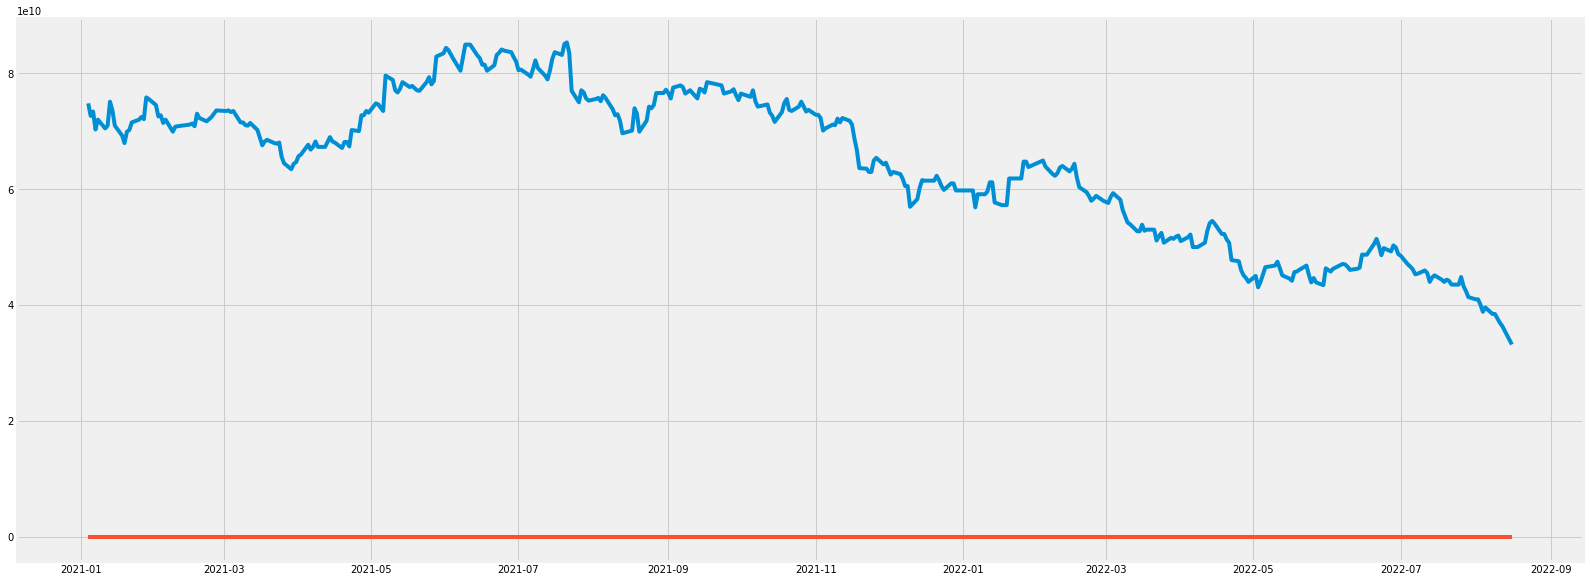

Epoch 2 / 11
399/399 [==============================] - 3s 8ms/step - loss: 122761871360.0000 - val_loss: 122761306112.0000
Epoch 3 / 11
399/399 [==============================] - 4s 10ms/step - loss: 122760683520.0000 - val_loss: 122760257536.0000
Epoch 4 / 11
399/399 [==============================] - 4s 9ms/step - loss: 122759806976.0000 - val_loss: 122759258112.0000
Epoch 5 / 11
399/399 [==============================] - 4s 10ms/step - loss: 122758815744.0000 - val_loss: 122758340608.0000
Epoch 6 / 11
399/399 [==============================] - 4s 10ms/step - loss: 122757914624.0000 - val_loss: 122757431296.0000


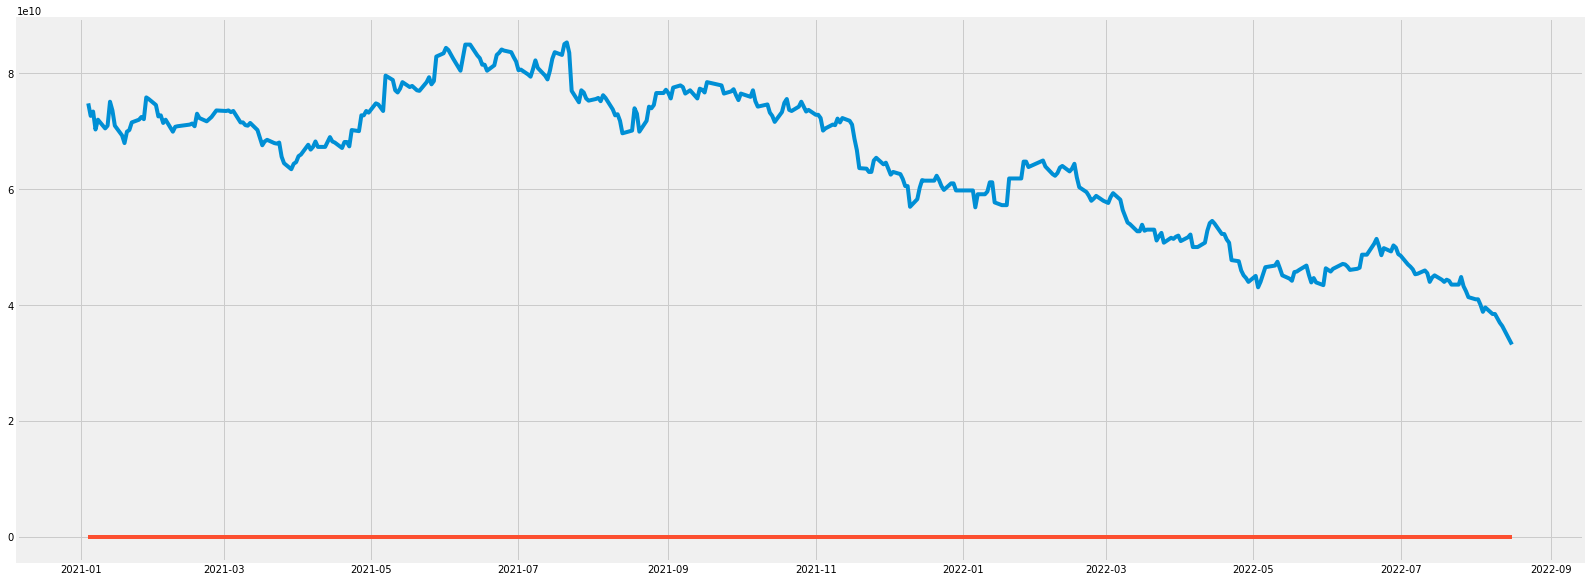

Epoch 7 / 11
399/399 [==============================] - 3s 8ms/step - loss: 122756816896.0000 - val_loss: 122756333568.0000
Epoch 8 / 11
399/399 [==============================] - 4s 9ms/step - loss: 122755784704.0000 - val_loss: 122755252224.0000
Epoch 9 / 11
399/399 [==============================] - 4s 9ms/step - loss: 122754818048.0000 - val_loss: 122754252800.0000
Epoch 10 / 11
399/399 [==============================] - 4s 10ms/step - loss: 122753777664.0000 - val_loss: 122753236992.0000
Epoch 11 / 11
399/399 [==============================] - 4s 9ms/step - loss: 122752770048.0000 - val_loss: 122752278528.0000


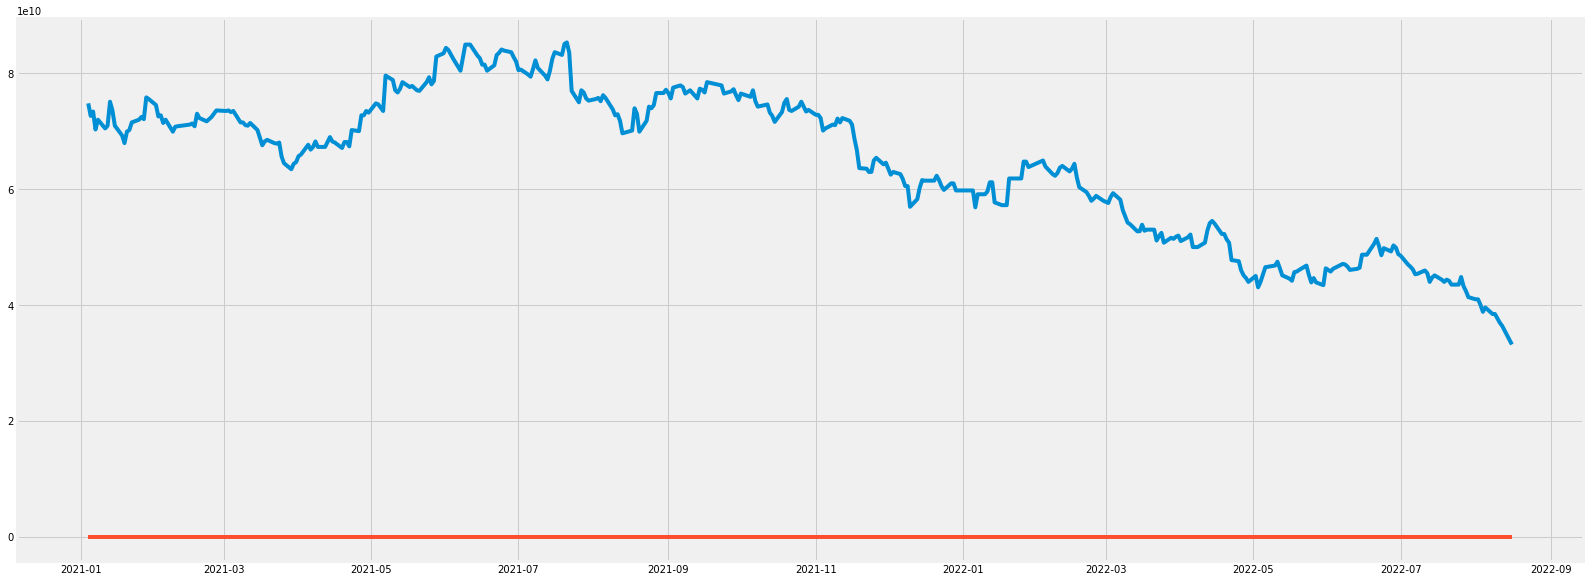

In [ ]:
def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(16,
                   batch_input_shape=(batch_size, n_steps, n_features),
                   stateful=stateful
                   ))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

batch_size = 1
epochs = 11

x, y = step_split(scaler.transform(df), n_steps, n_features, n_predict_steps)
y = scaler.inverse_transform(y)


model_stateful = create_model(True, batch_size, n_steps, n_features)

for i in range(epochs): 
    print('Epoch', i + 1, '/', epochs)
    model_stateful.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=1,
                      verbose=1,
                      shuffle=False,
                      validation_data=(x_test, y_test)
                       )
    if i % 5 == 0:
      y_hat = model_stateful.predict(x, batch_size=batch_size)
      y_hat = scaler.inverse_transform(y_hat)

      plt.figure(figsize=(25, 10))
      plt.plot(df.index[:len(y_hat)],y[:len(y_hat)])
      plt.plot(df.index[:len(y_hat)],y_hat)
      plt.show()